In [9]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.camera import pixel_depth_2_xyz, xyz_2_pixel
from robot_utils.transform import aruns
from robot_utils.transform import T_FLURDF

import sys
sys.path.append("/home/masonbp/ford/fastsam3d")
from segment_track.fastsam_wrapper import FastSAMWrapper
from segment_track.observation import Observation

In [10]:
bag = "/home/masonbp/data/motlee_jan_2024/00/RR08.bag"
topic = "/RR08/l515/color/image_raw/compressed"
cam_info_topic = "/RR08/l515/color/camera_info"
topic_t0 = ImgData.topic_t0(bag, topic)
t0 = topic_t0 + 200
tf = topic_t0 + 240
pose_topic = "/RR08/t265/odom/sample"

img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic=topic,
    time_tol=.05,
    time_range=[t0, tf]
)
pose_data = PoseData(
    data_file=bag,
    file_type='bag',
    topic=pose_topic,
    time_tol=10.,
    interp=True,
    T_postmultiply=T_FLURDF,
)

img_data.extract_params(cam_info_topic)
cam_params = img_data.camera_params

In [4]:
fastsam = FastSAMWrapper(
    weights="/home/masonbp/tools/fastsam/weights/FastSAM-x.pt",
    imgsz=256,
    device='cpu'
)
img_area = cam_params.width * cam_params.height
fastsam.setup_filtering(
    ignore_people=True,
    yolo_det_img_size=(128, 128),
    allow_tblr_edges=[True, False, False, False],
    area_bounds=[img_area / 20**2, img_area / 3**2]
)

Fusing layers... 


<Axes: >

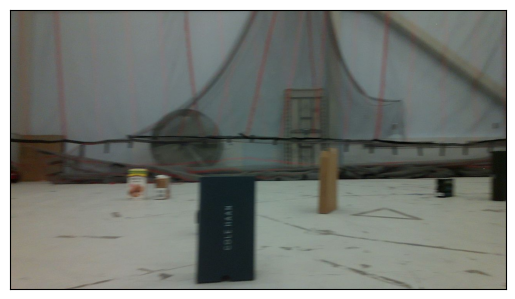

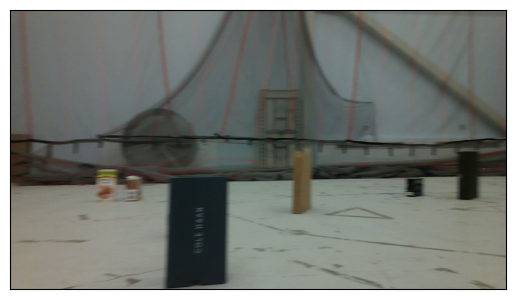

In [18]:
t1 = t0+1.8
t2 = t1 + .1

img_data.show(t1)
img_data.show(t2)


0: 160x256 8 objects, 104.8ms
Speed: 0.6ms preprocess, 104.8ms inference, 18.1ms postprocess per image at shape (1, 3, 256, 256)


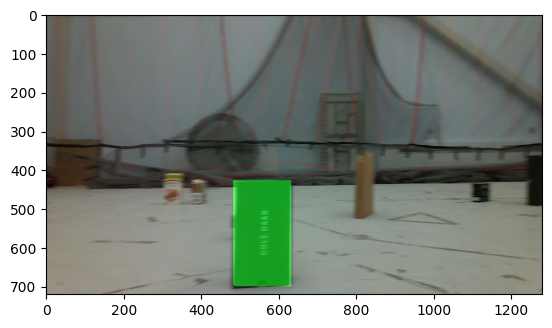

In [19]:

color = np.array([0, 255, 0])
img = img_data.img(t1)[...,::-1]
observations = fastsam.run(t1, pose_data.T_WB(t1), img)

colored_mask = observations[0].mask.astype(np.int32)[..., np.newaxis]*color
colored_mask = colored_mask.astype(np.uint8)
img = cv.addWeighted(img, 1.0, colored_mask, 0.5, 0)
plt.imshow(img)




In [20]:
def rotate_mask(mask, obs: Observation, R_P1_P2):
    print(R_P1_P2)
    keypoints = [np.array([obs.pixel[0] - obs.width / 2, obs.pixel[1] + obs.height / 2]),
                 np.array([obs.pixel[0] + obs.width / 2, obs.pixel[1] + obs.height / 2]),
                 np.array([obs.pixel[0] + obs.width / 2, obs.pixel[1] - obs.height / 2]),
                 np.array([obs.pixel[0] - obs.width / 2, obs.pixel[1] - obs.height / 2])]
    keypoints3D = [pixel_depth_2_xyz(*kp.tolist(), 1., cam_params.K) for kp in keypoints]
    print(keypoints)
    keypoints3D = [(R_P1_P2.T @ kp).reshape(-1) for kp in keypoints3D]
    rotated_keypoints = [xyz_2_pixel(kp, cam_params.K).reshape(-1) for kp in keypoints3D]
    print(rotated_keypoints)
    T2D = aruns(np.array(rotated_keypoints), np.array(keypoints))


    mask = mask.astype(np.float32)
    mask = cv.warpAffine(mask, T2D[:2, :3], (mask.shape[1], mask.shape[0]))
    return mask.astype(np.uint8), np.array(rotated_keypoints)

uint8
[[     0.9976  -0.0015218    0.069282]
 [   0.001478           1   0.0006842]
 [  -0.069283 -0.00058016      0.9976]]
[array([     483.02,      698.95]), array([     632.02,      698.95]), array([     632.02,      427.95]), array([     483.02,      427.95])]
[array([     418.48,      703.36]), array([        570,      699.26]), array([     569.59,       427.6]), array([     418.03,      428.54])]
uint8


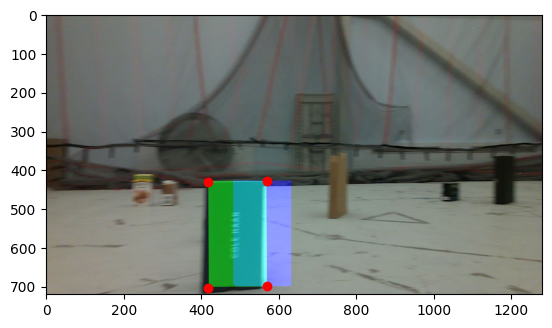

In [25]:
img = img_data.img(t2)[...,::-1]

other_mask = observations[0].mask.astype(np.uint8)[..., np.newaxis]*np.array([0, 0, 255], dtype=np.uint8)
colored_mask = observations[0].mask.astype(np.int32)[..., np.newaxis]*color
colored_mask = colored_mask.astype(np.uint8)
print(colored_mask.dtype)
# rotate_mask(colored_mask, observations[0], (np.linalg.inv(pose_data.T_WB(t1)) @ pose_data.T_WB(t2))[:3, :3])
colored_mask, rotated_kp = rotate_mask(colored_mask, observations[0], (np.linalg.inv(pose_data.T_WB(t1)) @ pose_data.T_WB(t2))[:3, :3])
print(colored_mask.dtype)


img = cv.addWeighted(img, 1.0, colored_mask, 0.5, 0)
img = cv.addWeighted(img, 1.0, other_mask, 0.5, 0)
plt.imshow(img)
plt.plot(rotated_kp[:,0], rotated_kp[:,1], 'ro')

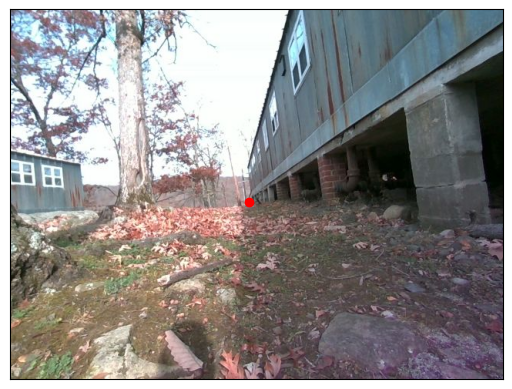

In [ ]:
ax = img_data.show(t0)
pixel = 310, 250
ax.plot(pixel[0], pixel[1], 'ro')

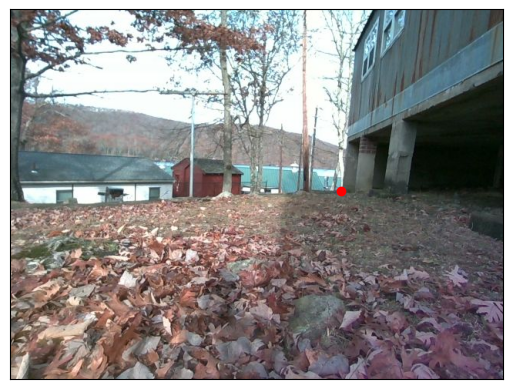

In [ ]:
# ax = img_data.show(t0+10)
# new_pixel = 285, 215
ax = img_data.show(t0+25)
new_pixel = 430, 235
ax.plot(new_pixel[0], new_pixel[1], 'ro')

In [ ]:
def fundamental_matrix(T, K):
    R = T[:3, :3]
    t = T[:3, 3]
    t_hat = np.array([
        [0, -t[2], t[1]],
        [t[2], 0, -t[0]],
        [-t[1], t[0], 0]
    ])
    return np.linalg.inv(K).T @ t_hat @ R @ np.linalg.inv(K)

T = np.linalg.inv(pose_data.T_WB(t0)) @ pose_data.T_WB(t0+25)
F = fundamental_matrix(T, cam_params.K)
print(F)
print(np.array([new_pixel[0], new_pixel[1], 1]).reshape((1,3)) @ F @ np.array([pixel[0], pixel[1], 1]).reshape((3,1)))

[[ 2.0157e-05  0.00011692   -0.035231]
 [-0.00011691  2.0937e-05    0.027664]
 [   0.017459   -0.046841      6.9161]]
[[  -0.060553]]


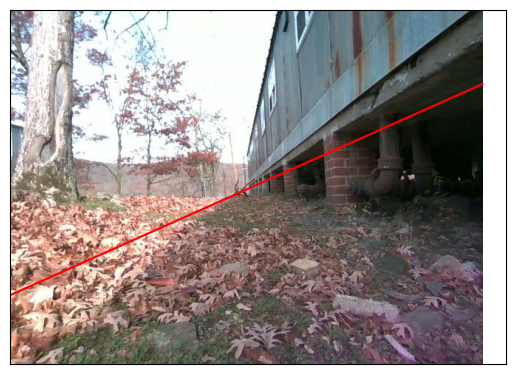

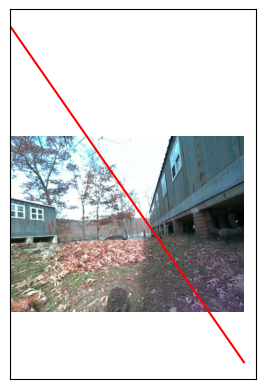

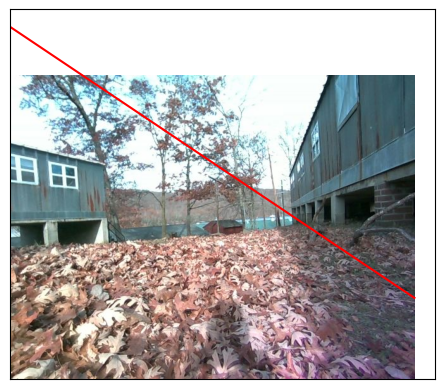

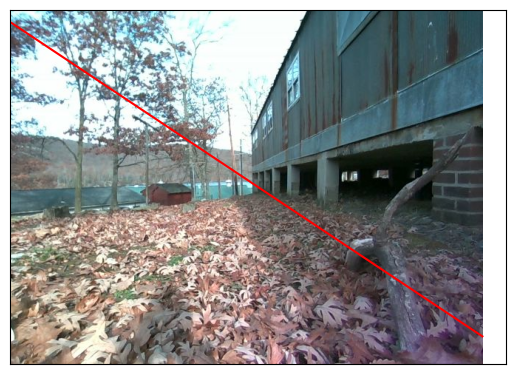

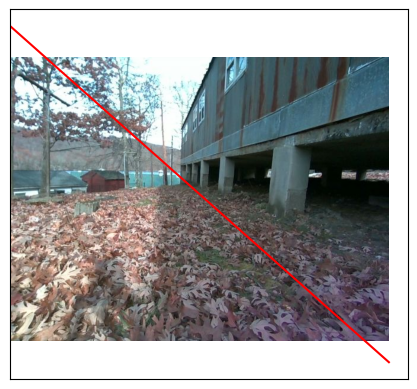

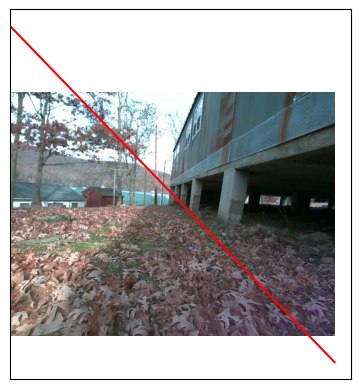

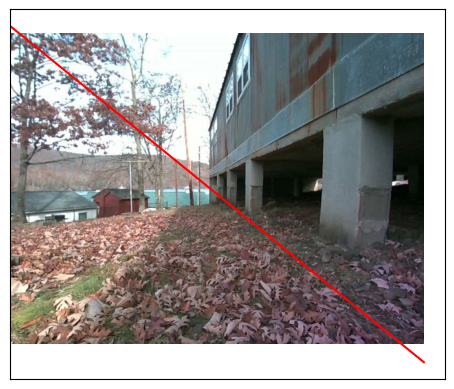

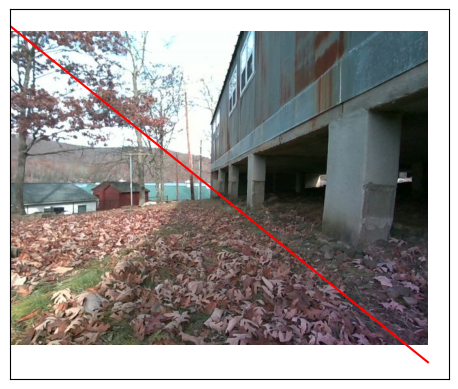

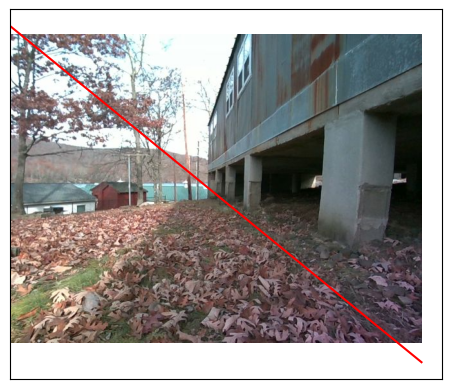

In [ ]:
for ti in range(2, 20, 2):
    t2 = t1 + ti
    T = np.linalg.inv(np.linalg.inv(pose_data.T_WB(t1)) @ pose_data.T_WB(t2))
    F = fundamental_matrix(T, cam_params.K)
    epipolar_line = F @ np.array([[pixel[0], pixel[1], 1]]).T

    height, width = img.shape[:2]
    x0, y0 = map(int, [0, -epipolar_line[2] / epipolar_line[1]])  # intersection with left image border
    x1, y1 = map(int, [width, -(epipolar_line[0] * width + epipolar_line[2]) / epipolar_line[1]])  # intersection with right image border

    # Draw the line on the image
    ax = img_data.show(t2)
    ax.plot((x0, x1), (y0, y1), color='red')